# Lecture 5 and 6: Class demo

## Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

c = os.path.join(os.path.abspath(".."), (".."), "data/")
DATA_DIR = os.path.join(os.path.abspath(".."), "data/")
pd.set_option("display.max_colwidth", 200)

<br><br>

## Data and splitting

For this demo, we are going to use data previously collected from students in this course using a restaurants survey. You'll find a [wrangled version](https://github.com/UBC-CS/cpsc330-2025W1/blob/main/lectures/data/cleaned_restaurant_data.csv) in the course repository.

In [2]:
df = pd.read_csv(DATA_DIR + 'cleaned_restaurant_data.csv')

In [3]:
df

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name,target
0,Yes,3.0,29,10.0,120.0,Italian,medium,Yes,Ambience,NaN,dislike
1,Yes,2.0,23,3.0,20.0,Canadian/American,no music,No,food tastes bad,NaN,dislike
2,Yes,2.0,21,20.0,15.0,Chinese,medium,Yes,bad food,NaN,dislike
3,No,2.0,24,14.0,18.0,Other,medium,No,Overall vibe on the restaurant,NaN,dislike
4,Yes,5.0,23,30.0,20.0,Chinese,medium,Yes,A bad day,NaN,dislike
...,...,...,...,...,...,...,...,...,...,...,...
959,No,10.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like
960,Yes,1.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like
961,No,1.0,22,40.0,50.0,Chinese,medium,Yes,The self service sauce table is very clean and the sauces were always filled up.,Haidilao,like
962,Yes,3.0,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,like


In [4]:
df.describe()

,eat_out_freq,age,n_people,price
count,964.000000,964.000000,6.960000e+02,696.000000
mean,2.585187,23.975104,1.439254e+04,1472.179152
std,2.246486,4.556716,3.790481e+05,37903.575636
min,0.000000,10.000000,-2.000000e+00,0.000000
25%,1.000000,21.000000,1.000000e+01,18.000000
50%,2.000000,22.000000,2.000000e+01,25.000000
75%,3.000000,26.000000,3.000000e+01,40.000000
max,15.000000,46.000000,1.000000e+07,1000000.000000


Are there any unusual values in this data that you notice?

Let's get rid of these outliers. 

In [5]:
upperbound_price = 200
lowerbound_people = 1
df = df[~(df['price'] > 200)]
restaurant_df = df[~(df['n_people'] < lowerbound_people)]
restaurant_df.shape

(942, 11)

In [6]:
restaurant_df.describe()

,eat_out_freq,age,n_people,price
count,942.000000,942.000000,674.000000,674.000000
mean,2.598057,23.992569,24.973294,34.023279
std,2.257787,4.582570,22.016660,29.018622
min,0.000000,10.000000,1.000000,0.000000
25%,1.000000,21.000000,10.000000,18.000000
50%,2.000000,22.000000,20.000000,25.000000
75%,3.000000,26.000000,30.000000,40.000000
max,15.000000,46.000000,200.000000,200.000000


Let's also check missing values and data types

In [7]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 0 to 963
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   north_america    942 non-null    object 
 1   eat_out_freq     942 non-null    float64
 2   age              942 non-null    int64  
 3   n_people         674 non-null    float64
 4   price            674 non-null    float64
 5   food_type        674 non-null    object 
 6   noise_level      674 non-null    object 
 7   good_server      669 non-null    object 
 8   comments         461 non-null    object 
 9   restaurant_name  374 non-null    object 
 10  target           942 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 88.3+ KB


We aim to predict whether a restaurant is liked or disliked.

In [8]:
# Separate `X` and `y`. 

X = restaurant_df.drop(columns=['target'])
y = restaurant_df['target']

To demonstrate some concepts, I am adding some perturbation to the data - don't do this in real projects!

In [9]:
X.at[459, 'food_type'] = 'Quebecois'
X['price'] = X['price'] * 100  # Equivalent to converting price in cents

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

<br><br>

## Exploratory data analysis 

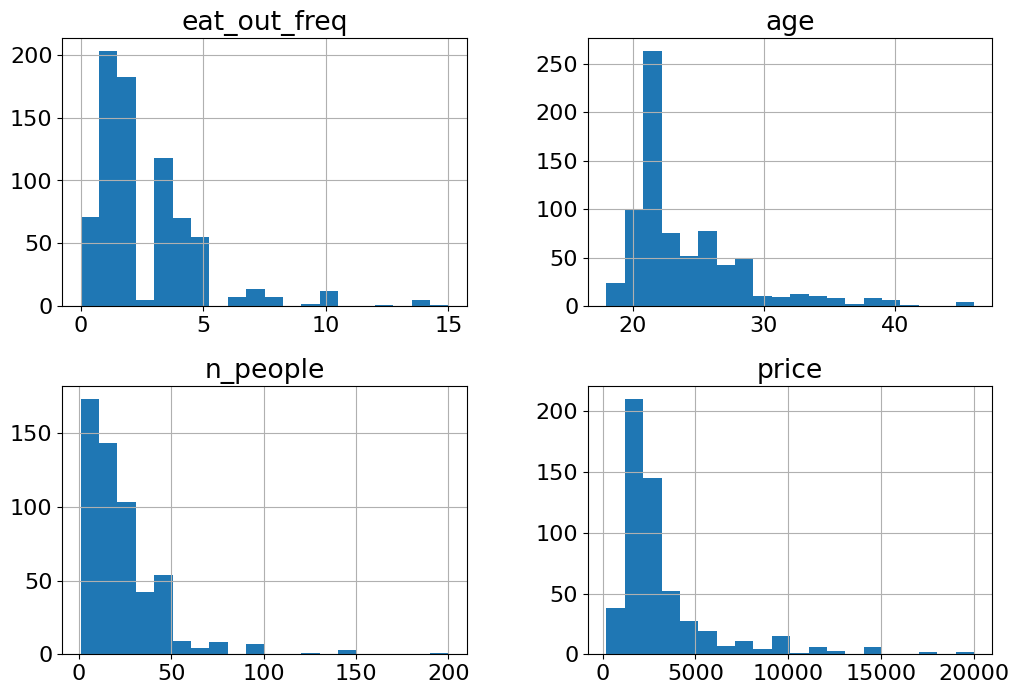

In [11]:
X_train.hist(bins=20, figsize=(12, 8));

Do you see anything interesting in these plots? 

In [12]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Thai                  20
Fusion                18
Mexican               17
fusion                 3
Quebecois              1
Name: count, dtype: int64

Error in data collection? Probably "Fusion" and "fusion" categories should be combined?

In [13]:
X_train['food_type'] = X_train['food_type'].replace("fusion", "Fusion")
X_test['food_type'] = X_test['food_type'].replace("fusion", "Fusion")

In [14]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

Again, usually we should spend lots of time in EDA, but let's stop here so that we have time to learn about transformers and pipelines.   

<br><br>

## Modeling 

### Dummy Classifier

In [15]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001602,0.001180,0.516556,0.514950
1,0.000960,0.000811,0.516556,0.514950
2,0.001235,0.000814,0.516556,0.514950
3,0.001137,0.000744,0.513333,0.515755
4,0.000843,0.000818,0.513333,0.515755


We have a relatively balanced distribution of both 'like' and 'dislike' classes.

<br><br>

### Let's try KNN on this data

Do you think KNN would work directly on `X_train` and `y_train`?

In [16]:
# Preprocessing and pipeline
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

- We need to preprocess the data before feeding it into machine learning models. 
- What transformations are necessary before training a machine learning model?
- Can we categorize features based on the type of transformations they require?

In [17]:
X_train[4:11]

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east
694,No,0.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,No,5.0,21,50.0,3500.0,Canadian/American,high,Yes,5,Joeys Shipyards
677,Yes,3.0,20,30.0,2000.0,Mexican,low,Yes,NaN,NaN
161,No,0.0,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,Yes,3.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Yes,2.0,21,30.0,3000.0,Chinese,medium,Yes,food that didn't come,Happy Lamb


In [18]:
numeric_feats = ['age', 'n_people', 'price'] # Continuous and quantitative features
# categorical_feats = [] # Discrete and qualitative features
# binary_feats = [] # Categorical features with only two possible values 
# ordinal_feats = [] # Some natural ordering in the categories 
# noise_cats = ['no music', 'low', 'medium', 'high', 'crazy loud']
drop_feats = ['comments', 'restaurant_name', 'eat_out_freq'] # Dropping text feats and `eat_out_freq` because it's not that useful

In [19]:
# In case we want to take a closer look at some features
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [20]:
numeric_feats = ['age', 'n_people', 'price'] # Continuous and quantitative features
categorical_feats = ['food_type', 'north_america'] # Discrete and qualitative features
binary_feats = ['good_server'] # Categorical features with only two possible values 
ordinal_feats = ['noise_level'] # Some natural ordering in the categories 
noise_cats = ['no music', 'low', 'medium', 'high', 'crazy loud']
drop_feats = ['comments', 'restaurant_name', 'eat_out_freq'] # Dropping text feats and `eat_out_freq` because it's not that useful

<br><br>

Let's start working with only numeric features. What if we just use numeric features to train a KNN model? Would it work? 

In [21]:
X_train_num = X_train[numeric_feats]
X_test_num = X_test[numeric_feats]
# knn.fit(X_train_num, y_train)

We still need to deal with NaN values. 

### sklearn's `SimpleImputer` 

In [22]:
# Impute numeric features using SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# fit the imputer 
imputer.fit(X_train_num)

# Transform training data 
X_train_num_imp = imputer.transform(X_train_num)

imputer.fit_transform(X_train_num)

# Transform test data 
X_test_num_imp = imputer.transform(X_test_num)

In [23]:
knn.fit(X_train_num_imp, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


No more errors. It worked! We can also score our model, but for now only on the training set. It is actually performing worse than the dummy classifier...

In [24]:
knn.score(X_train_num_imp, y_train)

0.6653386454183267

In [25]:
knn.score(X_test_num_imp, y_test)

0.49206349206349204

### Discussion questions 

- What's the difference between sklearn estimators and transformers?  
- Can you think of a better way to impute missing values? 

<br><br><br><br>

### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```    


### `sklearn` API summary: transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

Do we need to scale the data? 

In [26]:
X_train[numeric_feats]

,age,n_people,price
80,21,30.0,2200.0
934,21,30.0,3000.0
911,20,40.0,2500.0
459,21,NaN,NaN
62,24,20.0,3000.0
...,...,...,...
106,27,10.0,1500.0
333,24,12.0,800.0
393,20,5.0,1500.0
376,20,NaN,NaN


In [27]:
# Scale the imputed data 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_num_imp)
X_train_num_imp_scaled = scaler.transform(X_train_num_imp)
X_test_num_imp_scaled = scaler.transform(X_test_num_imp)

### Alternative methods for scaling
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform each feature to a desired range
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Scale features using median and quantiles. Robust to outliers. 
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): Works on rows rather than columns. Normalize examples individually to unit norm.
- [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): A scaler that scales each feature by its maximum absolute value.
    - What would happen when you apply `StandardScaler` to sparse data?    
- You can also apply custom scaling on columns using [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). For example, when a column follows the power law distribution (a handful of your values have many data points whereas most other values have few data points) log scaling is helpful.    

- For now, let's stick to `StandardScaler`, and use cross-validation to get a score on unseen data.

In [28]:
cross_val_score(knn, X_train_num_imp_scaled, y_train).mean()


np.float64(0.5232141280353201)

We see a small improvement. Usually, scaling is a good idea. 


- This worked but are we doing anything wrong here? 
- What's the problem with calling `cross_val_score` with preprocessed data? 


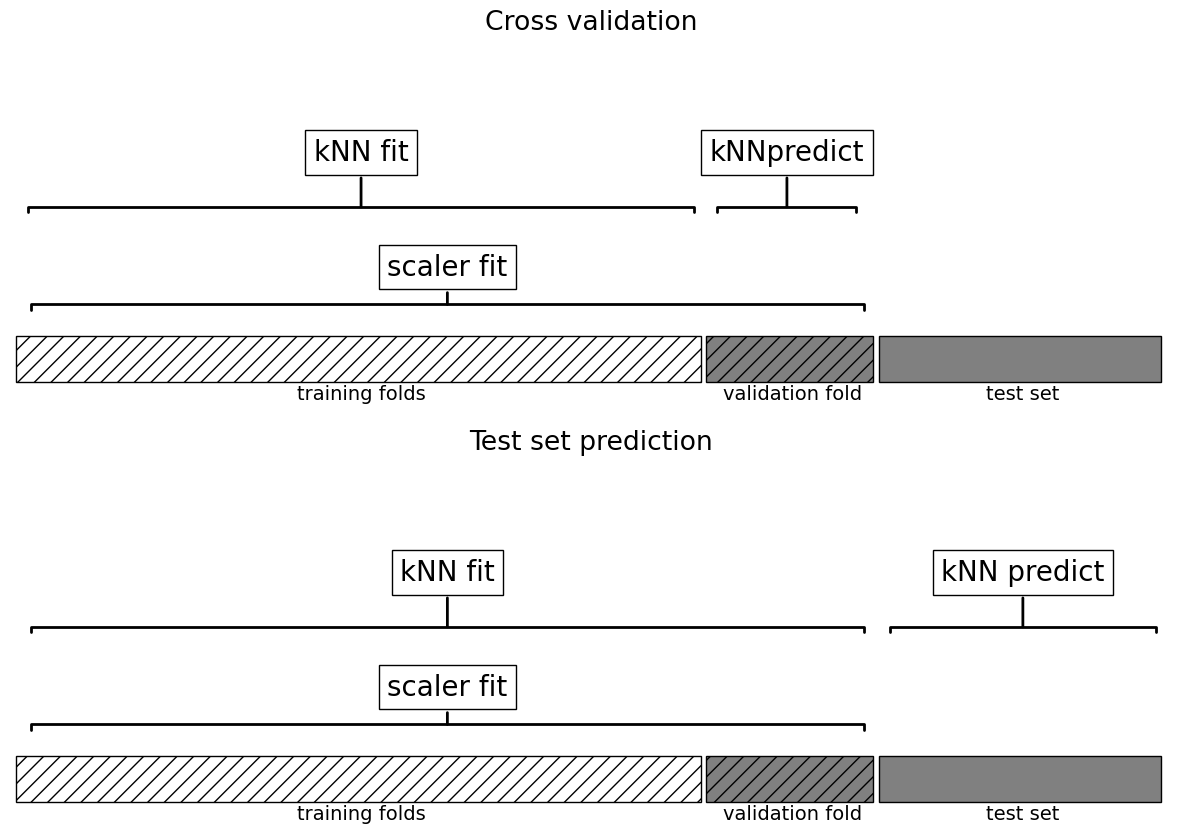

In [29]:
plot_improper_processing("kNN")

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information.
- In this example our validation accuracy looks fine, but our methodology is flawed.
- Implications can be significant in practice!


<br><br><br><br>

### How to do it properly? Enter sklearn pipelines!!

In [30]:
### Simple example of a pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", KNeighborsClassifier()),
    ]
)

- Syntax: pass in a list of steps.
- The last step should be a **model/classifier/regressor**.
- All the earlier steps should be **transformers**.

### Alternative and more compact syntax: `make_pipeline`

- Shorthand for `Pipeline` constructor
- Does not permit naming steps
- Instead the names of steps are set to lowercase of their types automatically; `StandardScaler()` would be named as `standardscaler`

In [31]:
# Create a pipeline 
pipe_knn = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(), 
    KNeighborsClassifier()
) 

In [32]:
pipe_knn.fit(X_train_num, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('simpleimputer', ...), ('standardscaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite

- Note that we are passing `X_train_num` and **not** the imputed or scaled data here. 

When you call `fit` on the pipeline, it carries out the following steps:

- Fit `SimpleImputer` on `X_train`
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Fit `StandardScaler` on `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`


In [33]:
pipe_knn.predict(X_train_num[0:10])

array(['dislike', 'dislike', 'like', 'like', 'dislike', 'like', 'dislike',
       'like', 'dislike', 'like'], dtype=object)

Note that we are passing original data to `predict` as well. This time the pipeline is carrying out following steps:
- Transform `X_train_num` using the fit `SimpleImputer` to create `X_train_num_imp`
- Transform `X_train_num_imp` using the fit `StandardScaler` to create `X_train_num_imp_scaled`
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_num_imp_scaled`. 

![](../img/pipeline.png)
<!-- <img src='./img/pipeline.png' width="800"> -->
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

### Let's try cross-validation with our pipeline 

In [34]:
cross_val_score(pipe_knn, X_train_num, y_train).mean()

np.float64(0.5205651214128035)

- What is happening under the hood? 
- Why is this a better approach? 

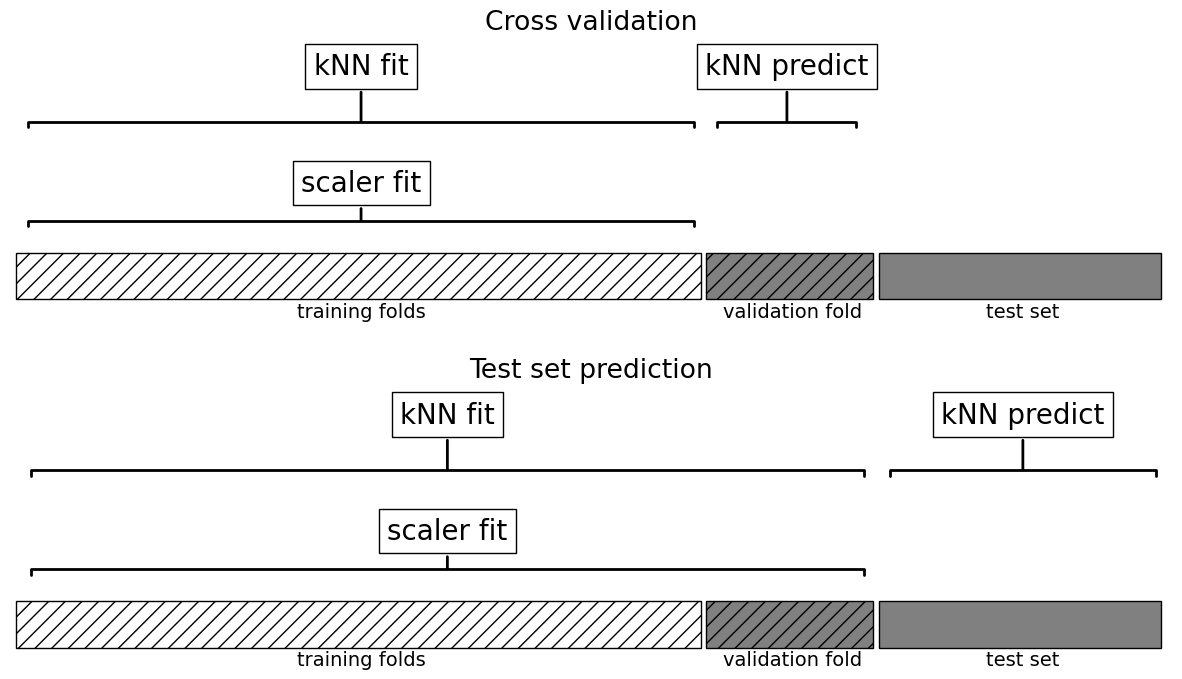

In [35]:
plot_proper_processing("kNN")

<br><br><br><br>

## Pause! 

We will continue with this demo in the next lecture by adding the remaining features.

### Categorical features

Let's assess the scores using only categorical features.

In [36]:
X_train['food_type'].value_counts()

food_type
Other                189
Canadian/American    131
Chinese              102
Indian                36
Italian               32
Fusion                21
Thai                  20
Mexican               17
Quebecois              1
Name: count, dtype: int64

In [37]:
X_train['north_america'].value_counts()

north_america
Yes                    415
No                     330
Don't want to share      8
Name: count, dtype: int64

In [38]:
X_train[categorical_feats]

,food_type,north_america
80,Chinese,No
934,Canadian/American,Yes
911,Canadian/American,No
459,Quebecois,Yes
62,Indian,Yes
...,...,...
106,Chinese,No
333,Other,No
393,Canadian/American,Yes
376,NaN,Yes


In [39]:
X_train_cat = X_train[categorical_feats]
X_test_cat = X_test[categorical_feats]

In [40]:
# One-hot encoding of categorical features 
from sklearn.preprocessing import OneHotEncoder
# Create class object
# ohe = OneHotEncoder()  this would yield a sparse matrix
ohe = OneHotEncoder(sparse_output = False)   # This yeilds a dense matrix

# fit OneHotEncoder
ohe.fit(X_train_cat, y_train)

X_train_cat_ohe  = ohe.transform(X_train_cat)# transform the train set
X_test_cat_ohe  =  ohe.transform(X_test_cat)# transform the test set

In [41]:
X_train_cat_ohe

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.]], shape=(753, 13))

- It's a sparse matrix. 
- Why? What would happen if we pass `sparse_output=False`? Why we might want to do that? 

In [42]:
# Get the OHE feature names 

ohe_feats = ohe.get_feature_names_out().tolist()
ohe_feats

['food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai',
 'food_type_nan',
 "north_america_Don't want to share",
 'north_america_No',
 'north_america_Yes']

In [43]:
pd.DataFrame(X_train_cat_ohe, columns = ohe_feats)

,food_type_Canadian/American,food_type_Chinese,food_type_Fusion,food_type_Indian,food_type_Italian,food_type_Mexican,food_type_Other,food_type_Quebecois,food_type_Thai,food_type_nan,north_america_Don't want to share,north_america_No,north_america_Yes
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
749,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
750,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [44]:
cross_val_score(knn, X_train_cat_ohe, y_train)

array([0.51655629, 0.55629139, 0.54304636, 0.54666667, 0.55333333])

Let's do this properly with a pipeline. 

In [45]:
# Code to create a pipeline for OHE and KNN
pipe_ohe_knn = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
    KNeighborsClassifier()
)

In [46]:
cross_val_score(pipe_ohe_knn, X_train_cat, y_train)

array([0.51655629, 0.55629139, 0.54304636, 0.54666667, 0.55333333])

### Ordinal features

Let's examine the scores using ordinal features.

In [47]:
noise_ordering = ['no music', 'low', 'medium', 'high', 'crazy loud']

In [48]:
X_train['noise_level'].value_counts()

noise_level
medium        232
low           186
high           75
no music       37
crazy loud     18
Name: count, dtype: int64

In [49]:
pipe_ordinal_knn = make_pipeline(
    OrdinalEncoder(categories=[noise_ordering]),
    KNeighborsClassifier()
)

In [50]:
# Uncomment to see the error

# cross_val_score(pipe_ordinal_knn, X_train[['noise_level']], y_train)

In [51]:
X_train['noise_level'].isnull().any()

np.True_

There are missing values. So we need an imputer. 

In [52]:
from sklearn.preprocessing import OrdinalEncoder
noise_ordering = ['no music', 'low', 'medium', 'high', 'crazy loud']

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[noise_ordering]),
    KNeighborsClassifier()
)

In [53]:
cross_val_score(ordinal_transformer, X_train[['noise_level']], y_train)

array([0.54966887, 0.52980132, 0.57615894, 0.50666667, 0.57333333])

Side note: what would happen if we did not specify the noise ordering?

In [54]:
X_train[['noise_level']].head()

,noise_level
80,high
934,low
911,medium
459,NaN
62,high


In [55]:
ord_imputer = SimpleImputer(strategy="most_frequent")

ord_enc = OrdinalEncoder()

X_train_ord = ord_enc.fit_transform(ord_imputer.fit_transform(X_train[['noise_level']]))
X_train_ord[0:5]

array([[1.],
       [2.],
       [3.],
       [3.],
       [1.]])

<br><br><br><br>

Right now we are working with numeric and categorical features separately. But ideally when we create a model, we need to use all these features together. 

**Enter column transformer!**

How can we horizontally stack  
- preprocessed numeric features, 
- preprocessed binary features, 
- preprocessed ordinal features, and 
- preprocessed categorical features?

Let's define a column transformer. 

In [56]:
from sklearn.compose import make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler()) 
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(drop="if_binary"))
ordinal_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OrdinalEncoder(categories=[noise_ordering]))
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(sparse_output=False, handle_unknown="ignore"))

# Define the column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (binary_transformer, binary_feats),
    (ordinal_transformer, ordinal_feats),
    (categorical_transformer, categorical_feats),    
    ("drop", drop_feats)    
)


In [57]:
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``fea

How does the transformed data look like? 

In [58]:
# Before transformation

X_train.shape

(753, 10)

In [59]:
# After

transformed = preprocessor.fit_transform(X_train)
transformed.shape

(753, 17)

In [60]:
# Getting feature names from a column transformer
ohe_feat_names = preprocessor.named_transformers_['pipeline-4']['onehotencoder'].get_feature_names_out(categorical_feats).tolist()
ohe_feat_names

['food_type_Canadian/American',
 'food_type_Chinese',
 'food_type_Fusion',
 'food_type_Indian',
 'food_type_Italian',
 'food_type_Mexican',
 'food_type_Other',
 'food_type_Quebecois',
 'food_type_Thai',
 "north_america_Don't want to share",
 'north_america_No',
 'north_america_Yes']

In [61]:
numeric_feats

['age', 'n_people', 'price']

In [62]:
feat_names = numeric_feats + binary_feats + ordinal_feats + ohe_feat_names

In [63]:
transformed

array([[-0.66941678,  0.31029469, -0.36840629, ...,  0.        ,
         1.        ,  0.        ],
       [-0.66941678,  0.31029469, -0.05422496, ...,  0.        ,
         0.        ,  1.        ],
       [-0.89515383,  0.82336432, -0.25058829, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.89515383, -0.97237936, -0.64331495, ...,  0.        ,
         0.        ,  1.        ],
       [-0.89515383, -0.20277493, -0.25058829, ...,  0.        ,
         0.        ,  1.        ],
       [-0.89515383,  1.33643394, -0.05422496, ...,  1.        ,
         0.        ,  0.        ]], shape=(753, 17))

In [64]:
pd.DataFrame(transformed, columns = feat_names)

,age,n_people,price,good_server,noise_level,food_type_Canadian/American,food_type_Chinese,food_type_Fusion,food_type_Indian,food_type_Italian,food_type_Mexican,food_type_Other,food_type_Quebecois,food_type_Thai,north_america_Don't want to share,north_america_No,north_america_Yes
0,-0.669417,0.310295,-0.368406,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.669417,0.310295,-0.054225,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.895154,0.823364,-0.250588,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.669417,-0.202775,-0.250588,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.007794,-0.202775,-0.054225,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,0.685006,-0.715845,-0.643315,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
749,0.007794,-0.613231,-0.918224,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
750,-0.895154,-0.972379,-0.643315,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
751,-0.895154,-0.202775,-0.250588,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


We have new columns for the categorical features. Let's create a pipeline with the preprocessor and SVC. 

In [65]:
from sklearn.svm import SVC 

svc_all_pipe = make_pipeline(preprocessor, SVC()) # create a pipeline with column transformer. 
cross_val_score(svc_all_pipe, X_train, y_train).mean()

np.float64(0.686569536423841)

We are getting better results! 
<br><br><br>

### Incorporating text features 

We haven't incorporated the comments feature into our pipeline yet, even though it holds significant value in indicating whether the restaurant was liked or not.

In [66]:
X_train

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name
80,No,2.0,21,30.0,2200.0,Chinese,high,No,The environment was very not clean. The food tasted awful.,NaN
934,Yes,4.0,21,30.0,3000.0,Canadian/American,low,Yes,The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.,NaN
911,No,4.0,20,40.0,2500.0,Canadian/American,medium,Yes,I was hungry,Chambar
459,Yes,5.0,21,NaN,NaN,Quebecois,NaN,NaN,NaN,NaN
62,Yes,2.0,24,20.0,3000.0,Indian,high,Yes,bad taste,east is east
...,...,...,...,...,...,...,...,...,...,...
106,No,3.0,27,10.0,1500.0,Chinese,medium,Yes,Food wasn't great.,NaN
333,No,1.0,24,12.0,800.0,Other,medium,Yes,NaN,NaN
393,Yes,4.0,20,5.0,1500.0,Canadian/American,low,No,NaN,NaN
376,Yes,5.0,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's create bag-of-words representation of the `comments` feature. But first we need to impute the rows where there are no comments. There is a small complication if we want to put `SimpleImputer` and `CountVectorizer` in a pipeline. 
- `SimpleImputer` takes a 2D array as input and produced 2D array as output. 
- `CountVectorizer` takes a 1D array as input. 

To deal with this, we will use sklearn's `FunctionTransformer` to convert the 2D output of `SimpleImputer` into a 1D array which can be passed to `CountVectorizer` as input. 

In [67]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

reshape_for_countvectorizer = FunctionTransformer(lambda X: X.squeeze(), validate=False)
text_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), 
                          reshape_for_countvectorizer, 
                          CountVectorizer(max_features=100, stop_words="english"))
text_pipe = make_pipeline(text_transformer, SVC())
cross_val_score(text_pipe, X_train[['comments']], y_train).mean()

np.float64(0.6453951434878586)

If we are curious, we can take a look at these new features

In [68]:
text_counts = text_transformer.fit_transform(X_train[['comments']])

bow_df = pd.DataFrame(
    text_counts.toarray(), columns=text_transformer.named_steps["countvectorizer"].get_feature_names_out(), index=X_train[['comments']]
)
bow_df

,amazing,ambiance,ambience,arrive,atmosphere,authentic,bad,best,chicken,clean,...,ve,vibe,vietnamese,view,wait,waitress,wasn,water,way,wrong
"(The environment was very not clean. The food tasted awful.,)",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
"(The building and the room gave a very comfy feeling. Immediately after sitting down it felt like we were right at home.,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(I was hungry,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(nan,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(bad taste,)",0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Food wasn't great. ,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
"(nan,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(nan,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(nan,)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
sorted_bow = pd.DataFrame(
    data=bow_df.sum(axis=0).tolist(),
    index=text_transformer.named_steps["countvectorizer"].get_feature_names_out(),
    columns=["counts"],
).sort_values("counts", ascending=False)

In [70]:
sorted_bow

,counts
missing,379
food,195
good,69
great,30
service,29
...,...
getting,3
kept,3
vibe,3
waitress,3


Pretty good scores just with text features! Do we get better scores if we combine all features? Let's define a column transformer which carries out 
- imputation and scaling on numeric features
- imputation and one-hot encoding with `drop="if_binary"` on binary features
- imputation and one-hot encoding with `handle_unknown="ignore"` on categorical features
- imputation, reshaping, and bag-of-words transformation on the text feature

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
text_feat = ['comments']

from sklearn.compose import make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler()) 
binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(drop="if_binary"))
ordinal_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OrdinalEncoder(categories=[noise_ordering]))
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                    OneHotEncoder(sparse_output=False, handle_unknown="ignore"))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (binary_transformer, binary_feats),    
    (categorical_transformer, categorical_feats),
    (ordinal_transformer, ordinal_feats),
    (text_transformer, text_feat),
)

In [72]:
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``fea

In [73]:
preprocessor.fit_transform(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6386 stored elements and shape (753, 117)>

In [74]:
svc_num_cat_text_pipe = make_pipeline(preprocessor, SVC())
cross_val_score(svc_num_cat_text_pipe, X_train, y_train).mean()

np.float64(0.7091920529801324)

Some improvement when we combine all features! 